# India News Data Exploration
    Basic NLP
-Pitchappan P RM

# Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import spacy
nlp=spacy.load("en_core_web_lg")
import sklearn.feature_extraction.text as text
import matplotlib.pyplot as plt
import textblob
from wordcloud import WordCloud,STOPWORDS
import PIL


# Reading Data

In [2]:
data=pd.read_csv("Data/india-news-headlines.csv")
data=data[['publish_date','headline_text']].drop_duplicates()
data['publish_date']=pd.to_datetime(data['publish_date'],format="%Y%M%d")
data['year']=data['publish_date'].dt.year

# Persistent Themes
To get a gist of what are the themes, that are being talked about, I followed a general approach of doing frequency counts, of unigrams, bigrams and trigrams on the whole dataset as well as for each year.

In [3]:
def get_imp(bow,mf,ngram):
    tfidf=text.CountVectorizer(bow,ngram_range=(ngram,ngram),max_features=mf,stop_words='english')
    matrix=tfidf.fit_transform(bow)
    return pd.Series(np.array(matrix.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False).head(100)

### Global trends
bow=data['headline_text'].tolist()
total_data=get_imp(bow,mf=5000,ngram=1)
total_data_bigram=get_imp(bow=bow,mf=5000,ngram=2)
total_data_trigram=get_imp(bow=bow,mf=5000,ngram=3)

### Yearly trends
imp_terms_unigram={}
for y in data['year'].unique():
    bow=data[data['year']==y]['headline_text'].tolist()
    imp_terms_unigram[y]=get_imp(bow,mf=5000,ngram=1)
imp_terms_bigram={}
for y in data['year'].unique():
    bow=data[data['year']==y]['headline_text'].tolist()
    imp_terms_bigram[y]=get_imp(bow,mf=5000,ngram=2)
imp_terms_trigram={}
for y in data['year'].unique():
    bow=data[data['year']==y]['headline_text'].tolist()
    imp_terms_trigram[y]=get_imp(bow,mf=5000,ngram=3)

### Common unigrams across all the years
common_unigram={}
for y in np.arange(2001,2017,1):
    if y==2001:       
        common_unigram[y]=set(imp_terms_unigram[y].index).intersection(set(imp_terms_unigram[y+1].index))
    else:
        common_unigram[y]=common_unigram[y-1].intersection(set(imp_terms_unigram[y+1].index))
        
### Common bigrams across all the years
common_bigram={}
for y in np.arange(2001,2017,1):
    if y==2001:
         common_bigram[y]=set(imp_terms_bigram[y].index).intersection(set(imp_terms_bigram[y+1].index))
    else:
        common_bigram[y]=common_bigram[y-1].intersection(set(imp_terms_bigram[y+1].index))
        
### Common trigrams, 1 year window
common_trigram_1yr={}
for y in np.arange(2001,2017,1):
    common_trigram_1yr[str(y)+"-"+str(y+1)]=set(imp_terms_trigram[y].index).intersection(set(imp_terms_trigram[y+1].index))

### Commin trigrams, 2 year window
common_trigram_2yr={}
for y in np.arange(2001,2015,3):
    if y==2001:
        common_trigram_2yr[str(y)+"-"+str(y+1)+"-"+str(y+2)]=set(imp_terms_trigram[y].index).intersection(set(imp_terms_trigram[y+1].index)).intersection(set(imp_terms_trigram[y+2].index))
    else:
        common_trigram_2yr[str(y)+"-"+str(y+1)+"-"+str(y+2)]=set(imp_terms_trigram[y].index).intersection(set(imp_terms_trigram[y+1].index)).intersection(set(imp_terms_trigram[y+2].index))
        

# Visualizations for the Top 20 unigrams, bigrams and trigrams

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

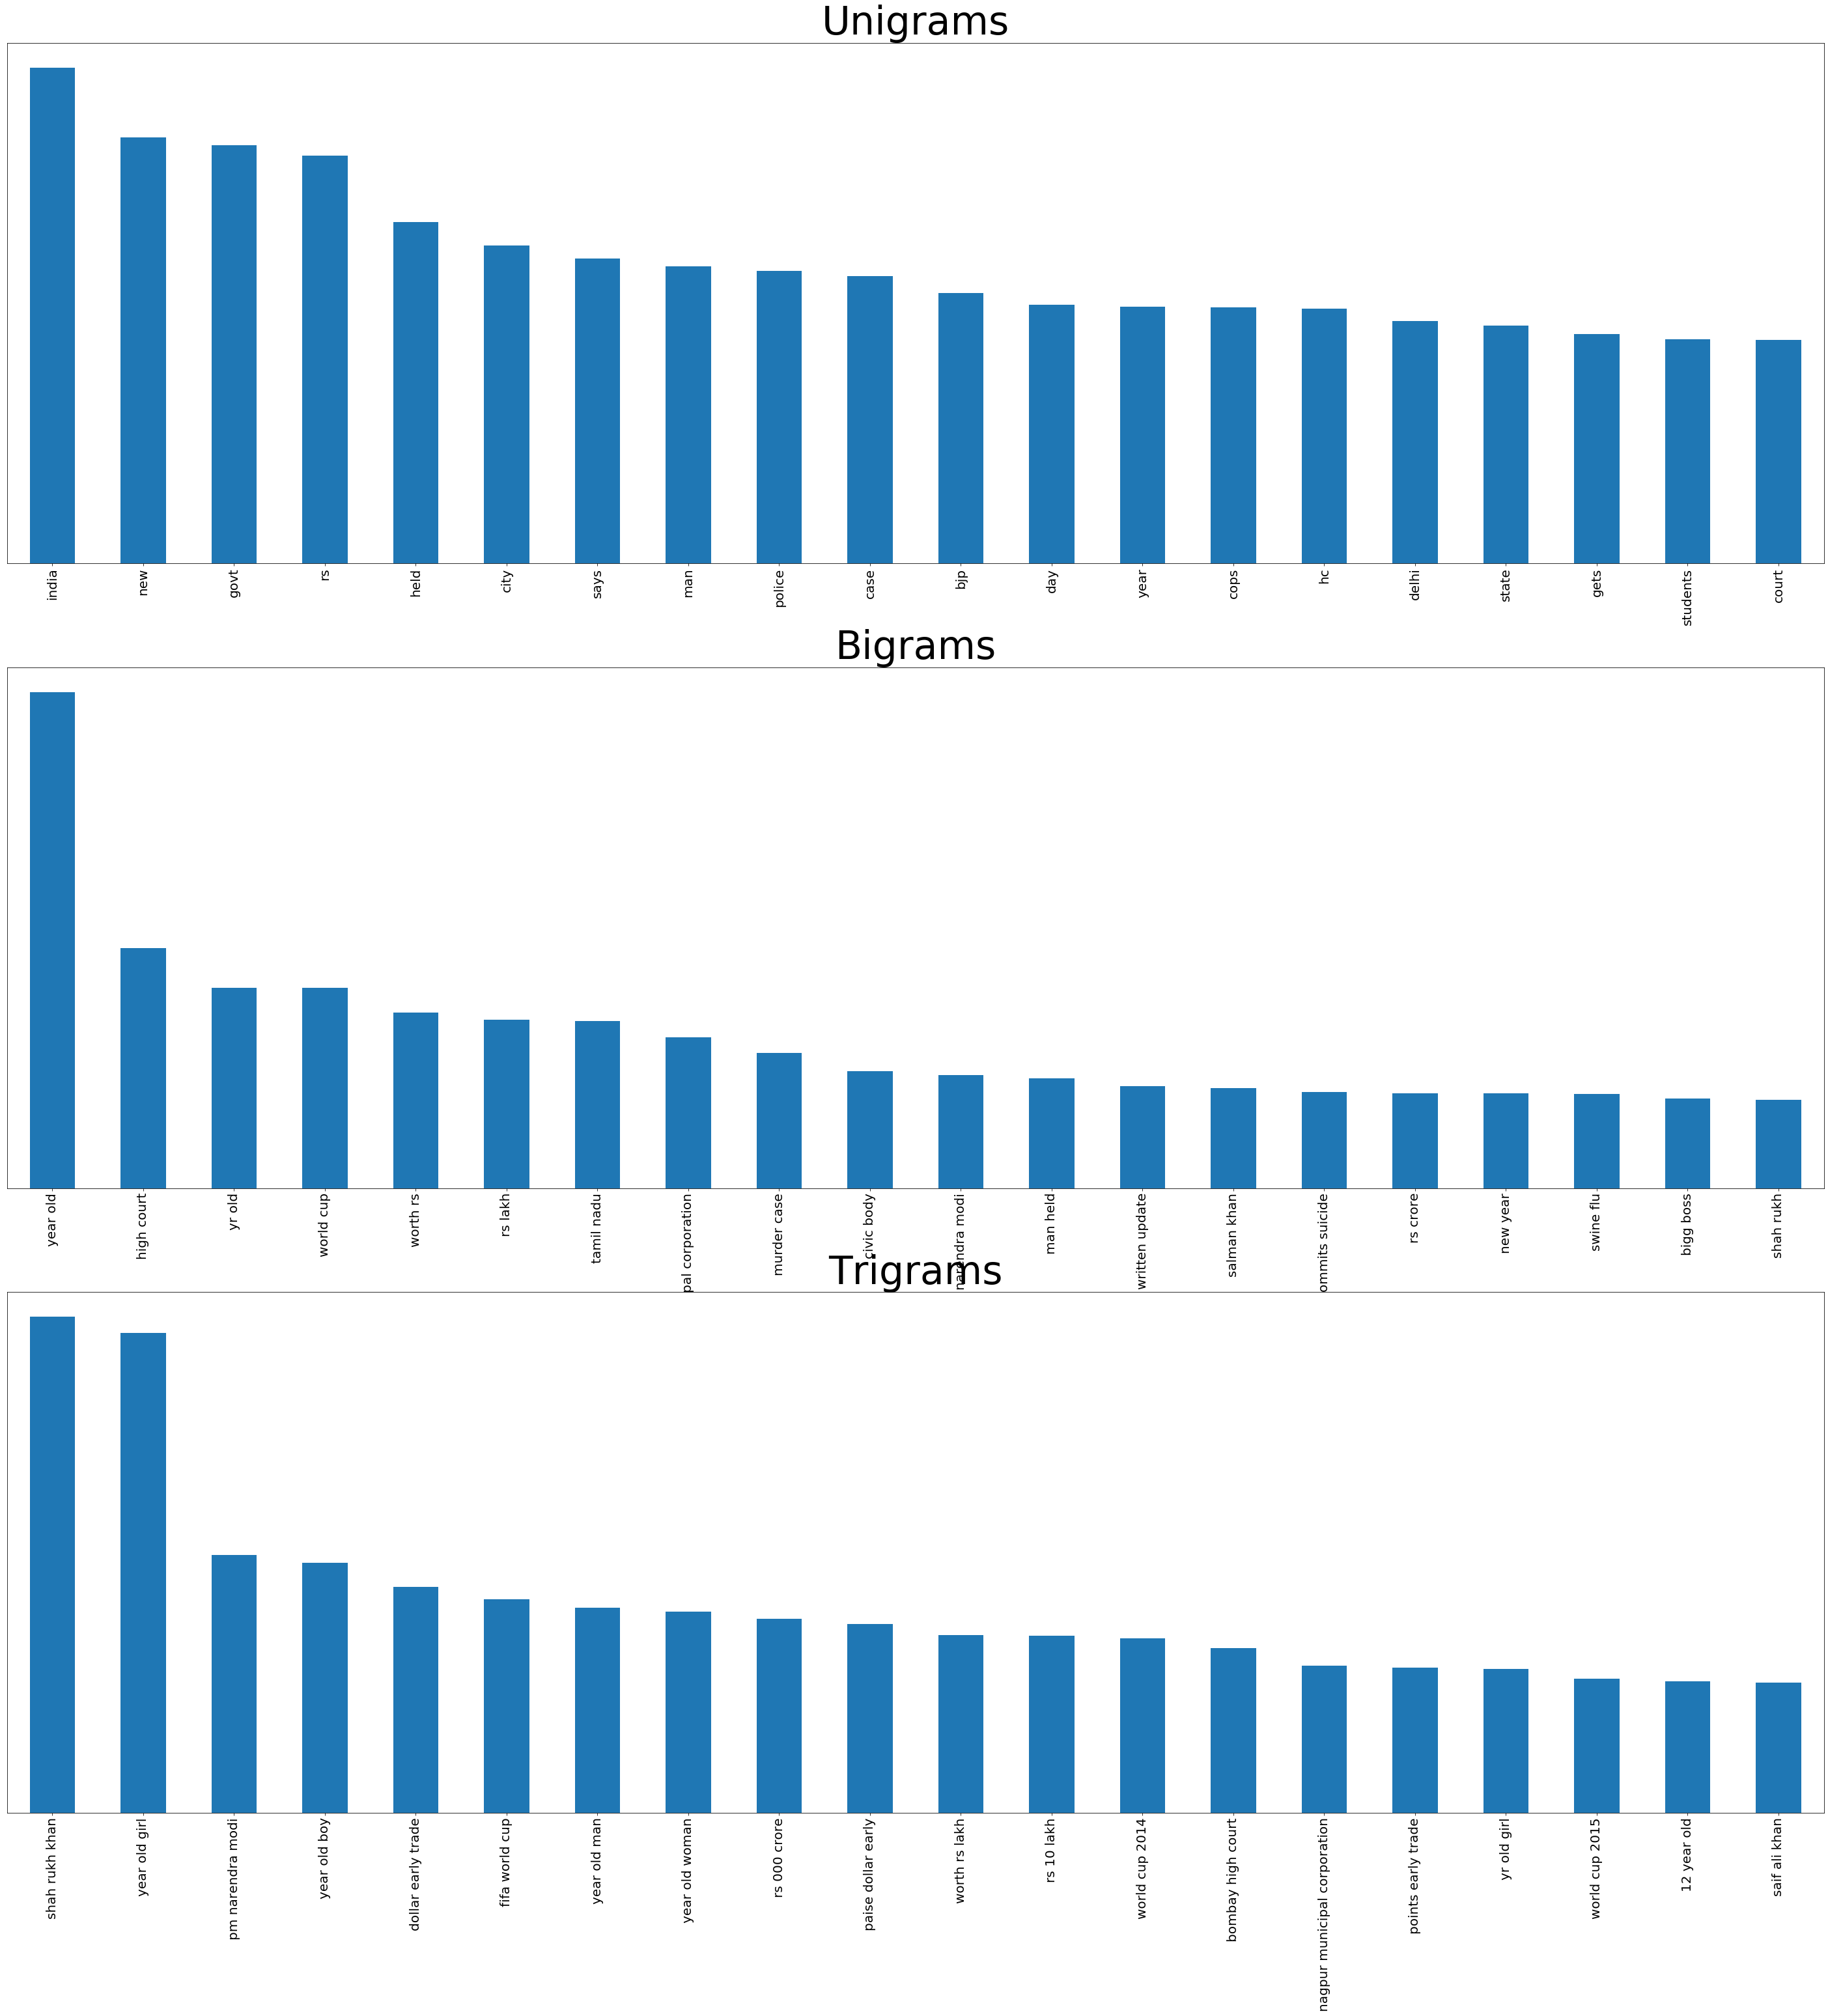

In [4]:
import matplotlib.pyplot as plt
plt.subplot(3,1,1)
total_data.head(20).plot(kind="bar",figsize=(50,50))
plt.title("Unigrams",fontsize=60)
plt.yticks([])
plt.xticks(size=20)
plt.subplot(3,1,2)
total_data_bigram.head(20).plot(kind="bar",figsize=(50,50))
plt.title("Bigrams",fontsize=60)
plt.yticks([])
plt.xticks(size=20)

plt.subplot(3,1,3)
total_data_trigram.head(20).plot(kind="bar",figsize=(50,50))
plt.title("Trigrams",fontsize=60)
plt.yticks([])
plt.xticks(size=20)

In [5]:
# viewing trigrams
print(total_data_trigram)

shah rukh khan                2064
year old girl                 1997
pm narendra modi              1074
year old boy                  1041
dollar early trade             941
                              ... 
high court seeks               296
hc issues notice               290
pimpri chinchwad municipal     287
pay rs lakh                    287
written update june            285
Length: 100, dtype: int64


We can see that Shah Rukh Khan seems to be the ost popular trigram in the news. Let's dig deeper on him

# Shah Rukh Khan analysis

Find headlines with the stars name

In [6]:
index_shah=data['headline_text'].str.match(r'(?=.*\bshah\b)(?=.*\brukh\b).*$',case=False)
data_shah=data.loc[index_shah].copy()
data_shah['polarity']=data_shah['headline_text'].map(lambda x: textblob.TextBlob(x).sentiment.polarity)

In [7]:
pos=data_shah.query("polarity>0")['headline_text']
neg=data_shah.query("polarity<0")['headline_text']
print("The number of positve headlines were {} times the negative headlines".format(round(len(pos)/len(neg),2)))

The number of positve headlines were 2.9 times the negative headlines


Text(0.5, 1.0, 'Frequency of Positive and Negative News about Shah Rukh')

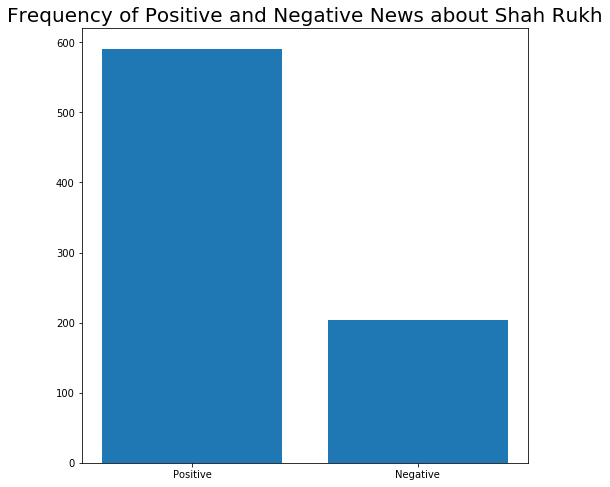

In [8]:
plt.figure(figsize=(8,8))
plt.bar(["Positive","Negative"],[len(pos),len(neg)])
plt.title("Frequency of Positive and Negative News about Shah Rukh",fontsize=20)

# lets see popular words that appear along with Shah Rukh Khan in the news

In [9]:
bow=data_shah['headline_text'].str.replace(r'shah|rukh|khan',"",case=False).tolist()
shah_uni=get_imp(bow,mf=5000,ngram=1)
shah_bi=get_imp(bow,mf=5000,ngram=2)
shah_tri=get_imp(bow,mf=5000,ngram=3)

Text(0.5, 1.0, 'Most Frequent unigrams in the Context of Shah Rukh')

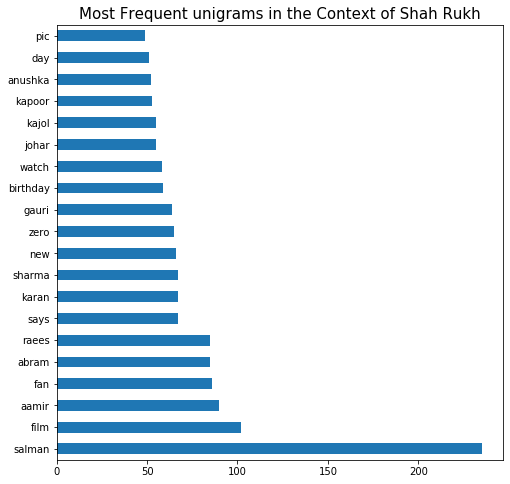

In [10]:
shah_uni.head(20).plot(kind="barh",figsize=(8,8))
plt.title("Most Frequent unigrams in the Context of Shah Rukh",fontsize=15)

Text(0.5, 1.0, 'Most Frequent Bigrams in the Context of Shah Rukh')

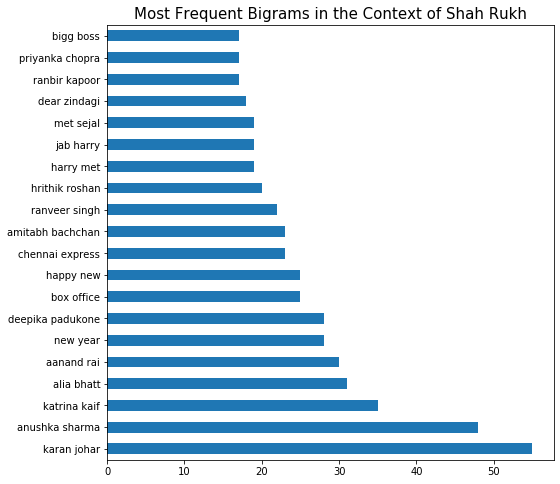

In [11]:
shah_bi.head(20).plot(kind="barh",figsize=(8,8))
plt.title("Most Frequent Bigrams in the Context of Shah Rukh",fontsize=15)

Text(0.5, 1.0, 'Most Frequent Bigrams in the Context of Shah Rukh')

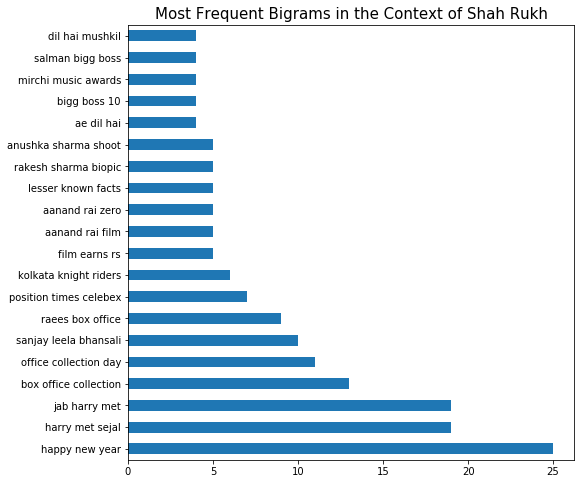

In [12]:
shah_tri.head(20).plot(kind="barh",figsize=(8,8))
plt.title("Most Frequent Bigrams in the Context of Shah Rukh",fontsize=15)

# let's create a wordcloud of Shah Rukh Khan news

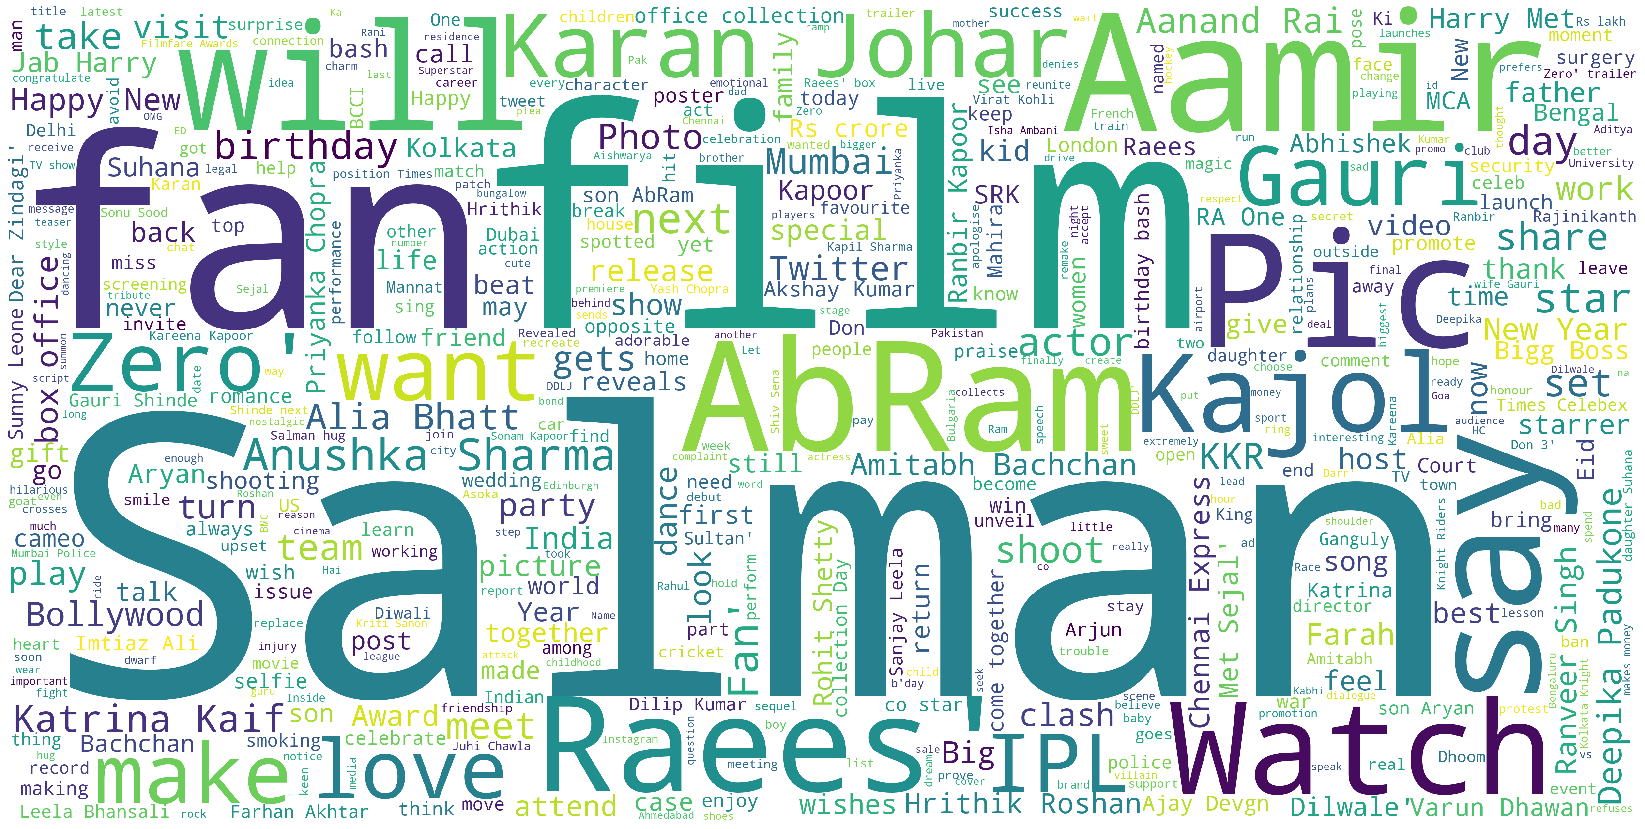

In [13]:
shah_text=" ".join(bow)
wc = WordCloud(max_words=500, width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(shah_text)
plt.figure( figsize=(30,15))
plt.imshow(wc)
plt.axis("off")
plt.yticks([])
plt.xticks([])
plt.savefig('Data/shahrukh_wordcloud.png', dpi=50)
plt.show()

# lets go back to bigrams and trigrams and see them yearwise

Top 10 bigrams across years

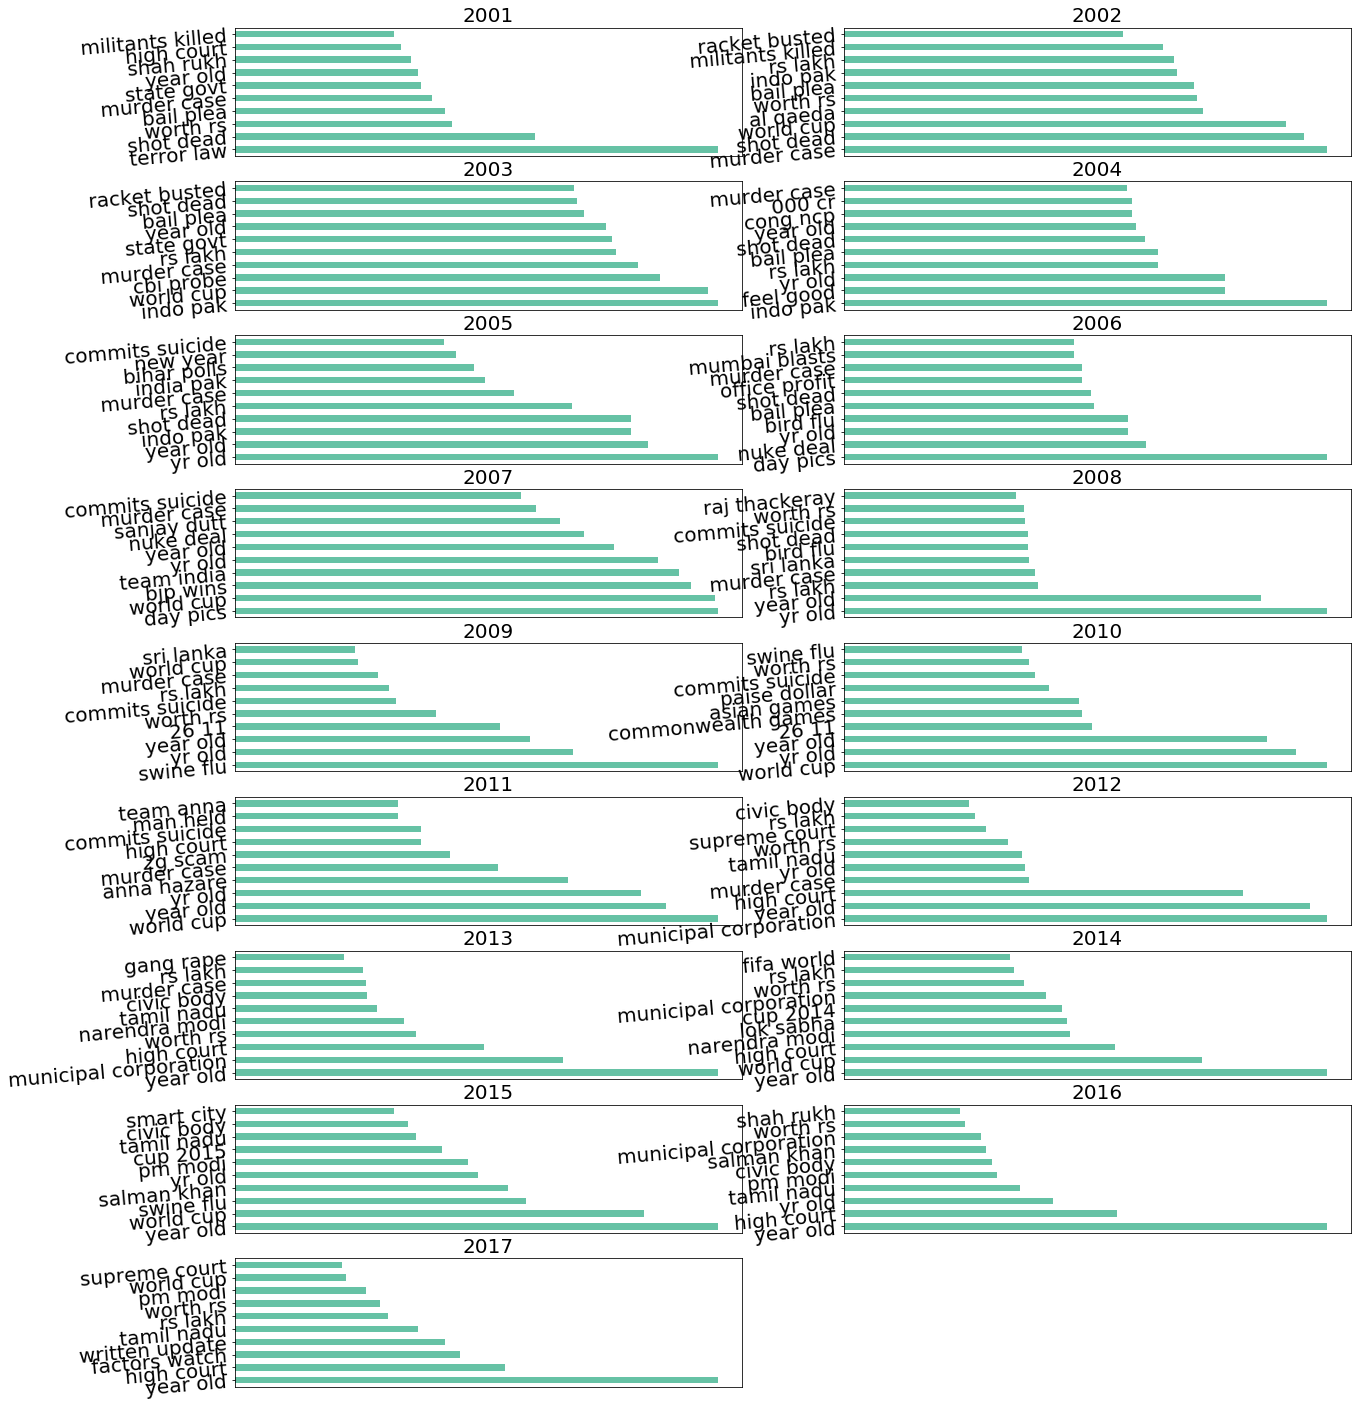

In [14]:
for i in range(1,18,1):
    plt.subplot(9,2,i)
    imp_terms_bigram[2000+i].head(10).plot(kind="barh",figsize=(20,25),colormap='Set2')
    plt.title(2000+i,fontsize=20)
    plt.xticks([])
    plt.yticks(size=20,rotation=5)


 Top 10 Trigrams across years

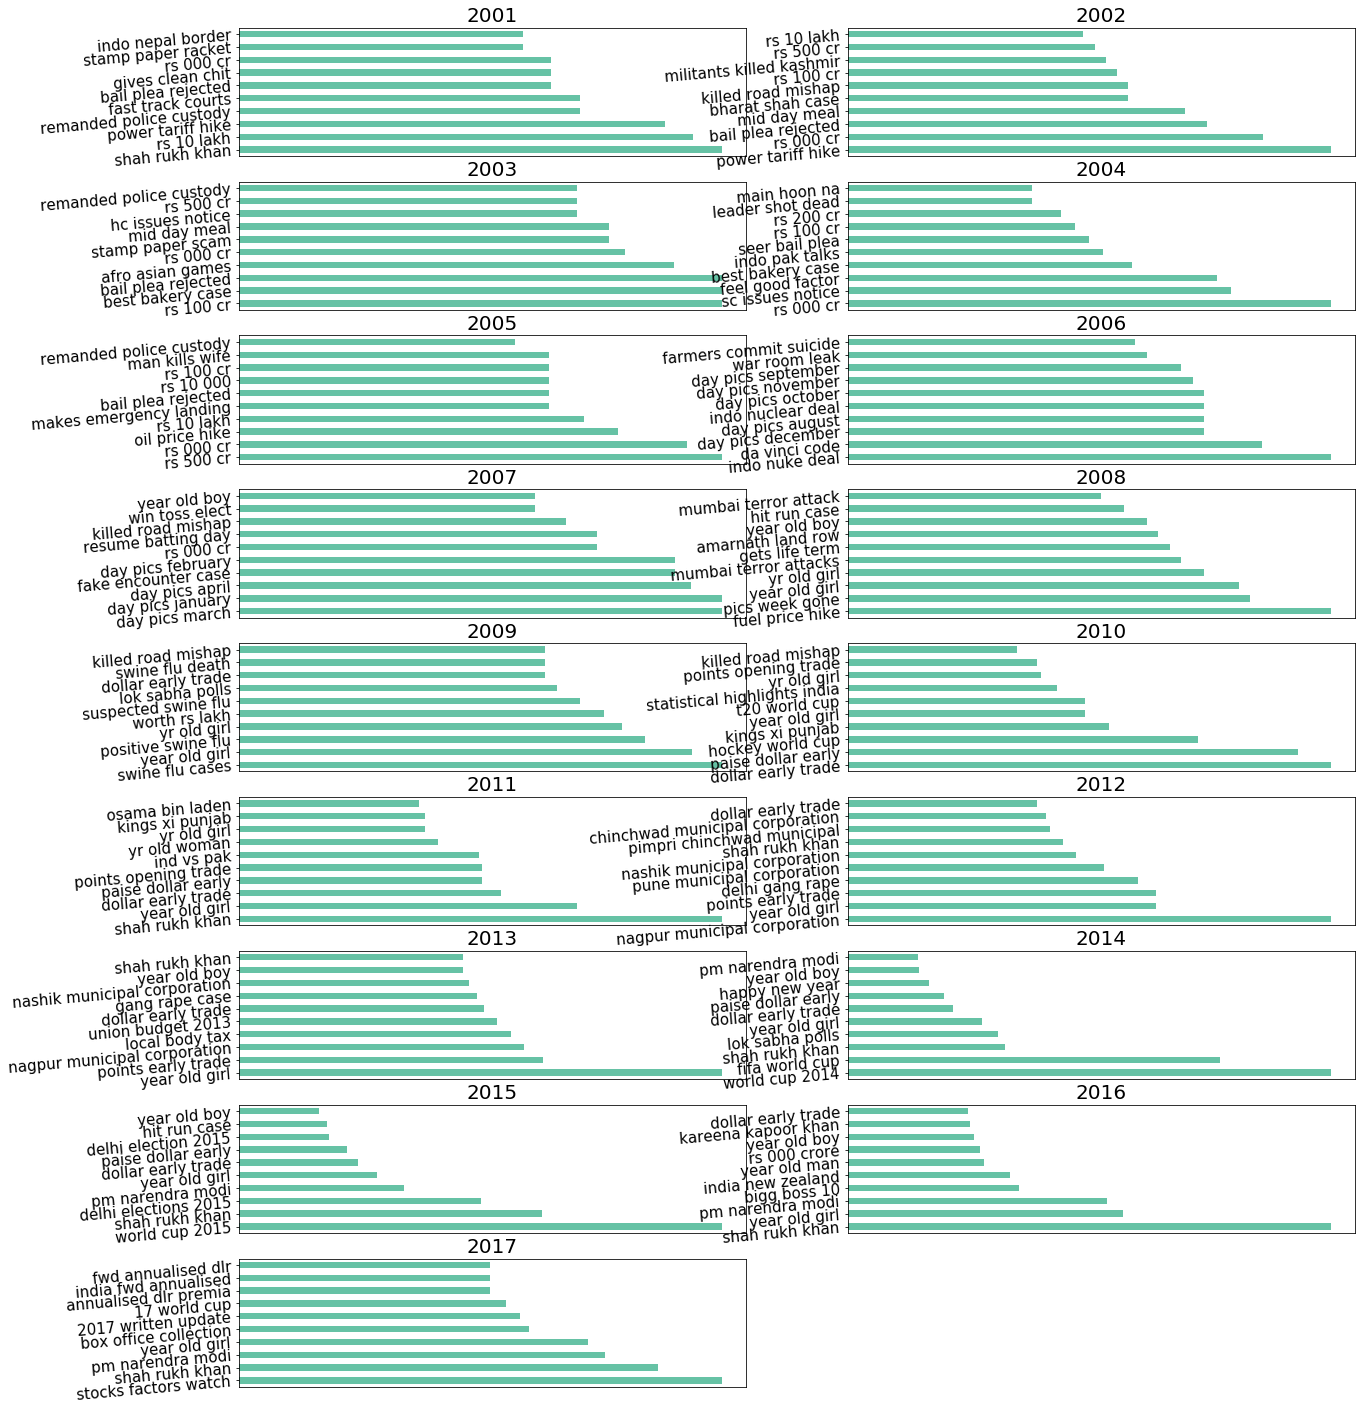

In [15]:
for i in range(1,18,1):
    plt.subplot(9,2,i)
    imp_terms_trigram[2000+i].head(10).plot(kind="barh",figsize=(20,25),colormap="Set2")
    plt.title(2000+i,fontsize=20)
    plt.xticks([])
    plt.yticks(size=15,rotation=5)


In [16]:
## Count of common tokens across the years
count_common_bi={}
for year in range(2001,2017,1):
    count_common_bi[year]=pd.Series()
    for word in common_bigram[year]:
        if year==2001:
            count_common_bi[year][word]=imp_terms_bigram[year][word]+imp_terms_bigram[year+1][word]
        else:
            count_common_bi[year][word]=count_common_bi[year-1][word]+imp_terms_bigram[year+1][word]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


Top 10 bigrams common across years

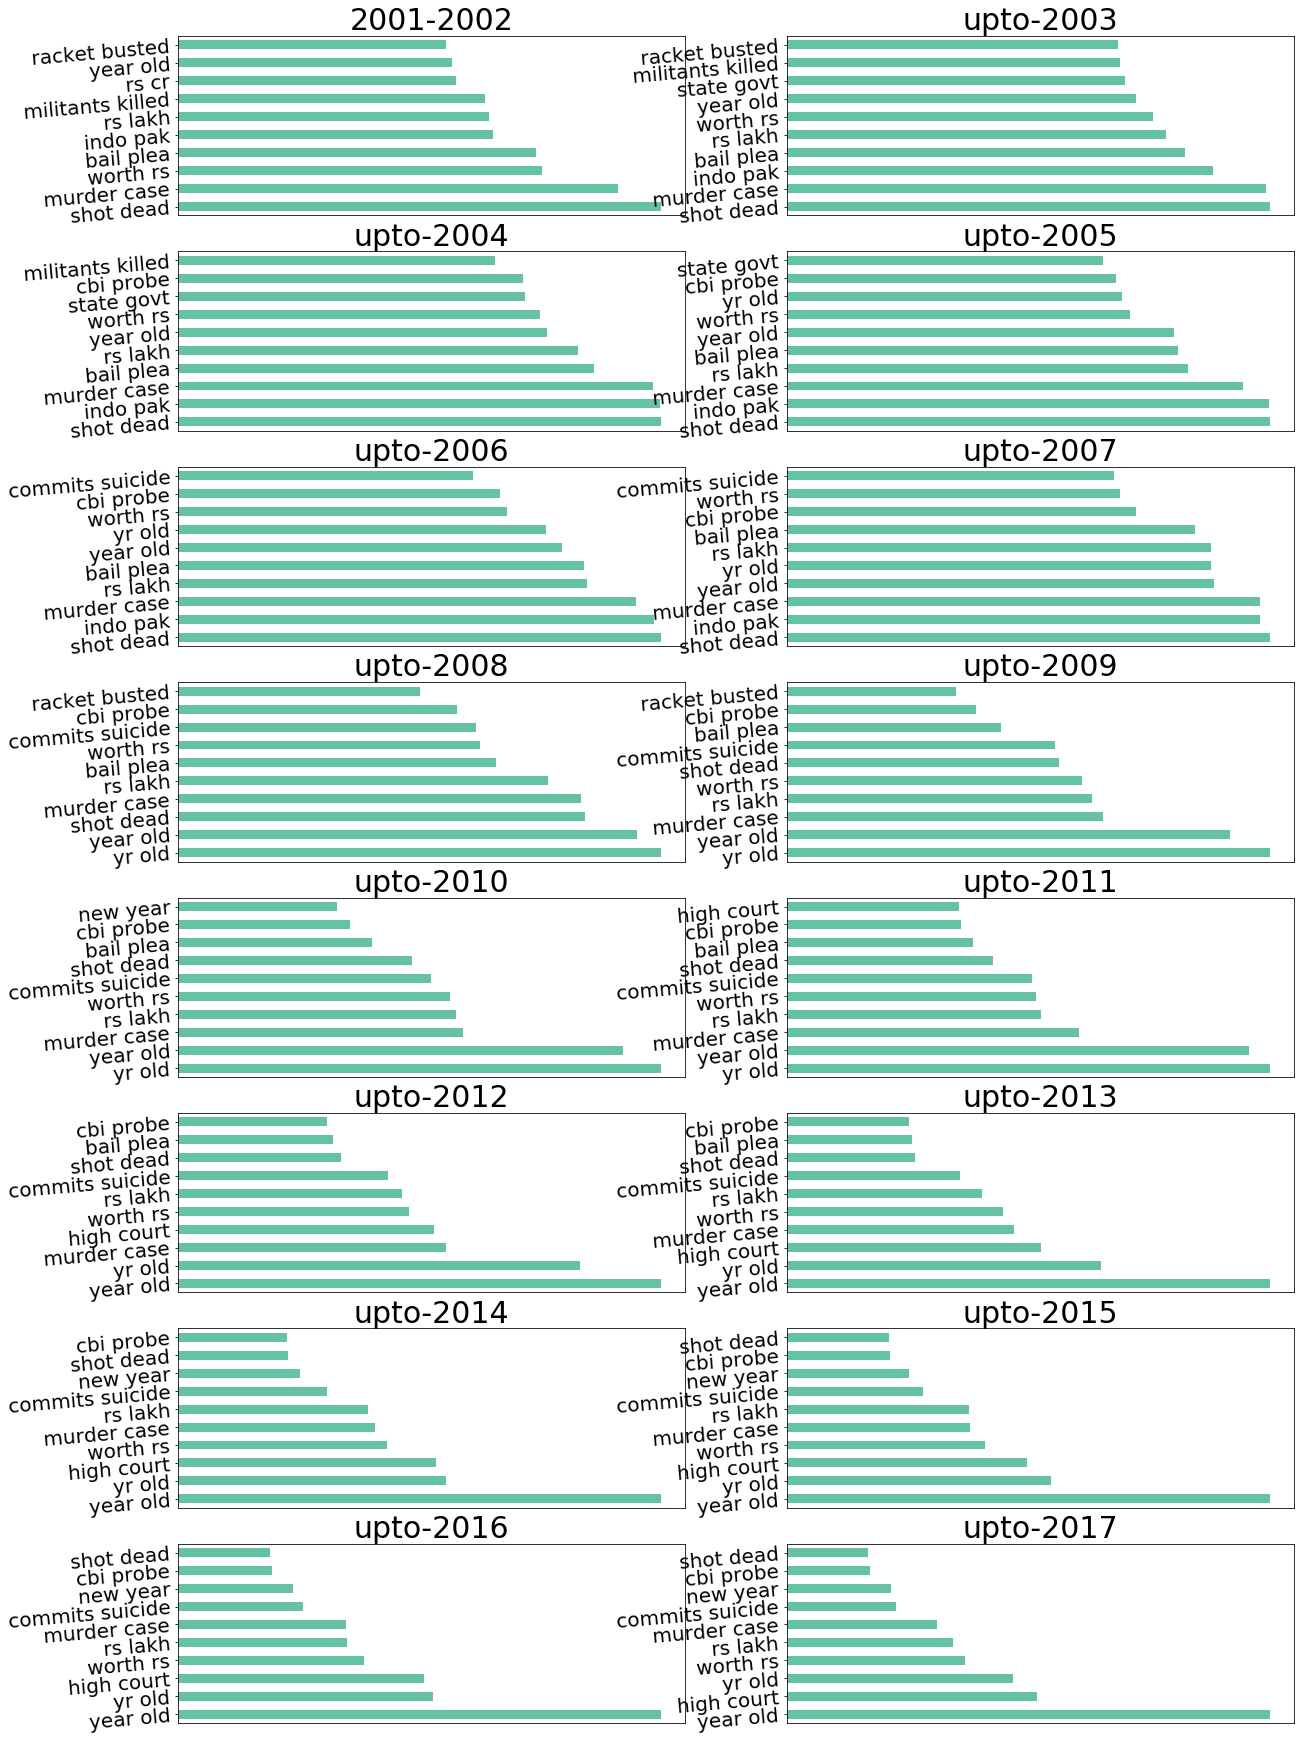

In [17]:

for i in range(1,17,1):
    plt.subplot(9,2,i)
    count_common_bi[2000+i].sort_values(ascending=False).head(10).plot(kind="barh",figsize=(20,35),colormap="Set2")
    if (2000+i)==2001:
        plt.title(str(2000+i)+"-"+str(2000+i+1),fontsize=30)
    else:
        plt.title("upto-"+str(2000+i+1),fontsize=30)
    plt.xticks([])
    plt.yticks(size=20,rotation=5)


While looking at the plot created above, one thing that strikes you is that crime reporting is very persistent. All the tokens in the above figure are actually, telling you the common bigrams from one year to another. One thing that strikes you is the fact that token **year old** and **commits suicide** are very prominent across years.

Let's just focus on the story behind the token 'year old'

In order to figure out the context around **year old**,
-  I found out which headlines contained this token
- Extracted the noun and verbs that occur with this token

([], <a list of 0 Text yticklabel objects>)

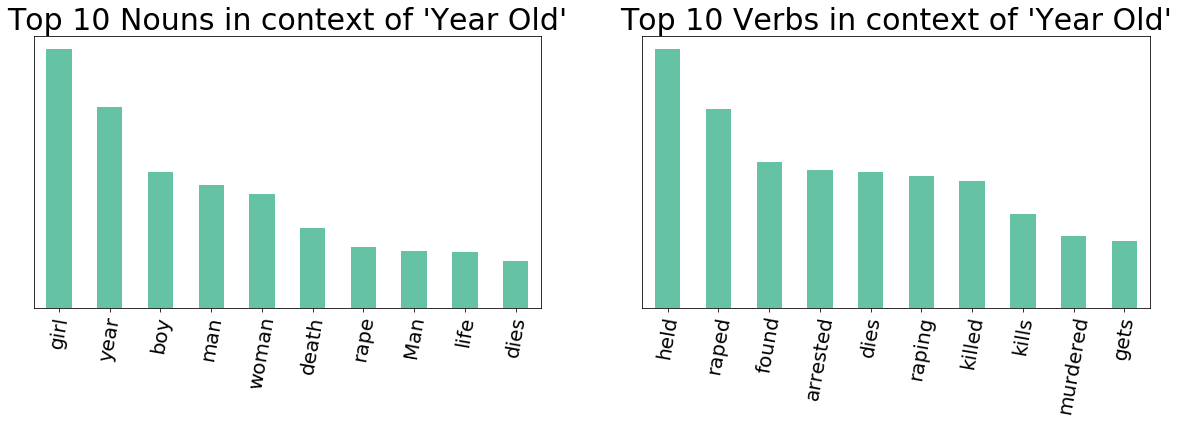

In [18]:
## Story of 'year old'
index=data['headline_text'].str.match(r'(?=.*\byear\b)(?=.*\bold\b).*$')
texts=data['headline_text'].loc[index].tolist()
noun=[]
verb=[]
for doc in nlp.pipe(texts,n_threads=16,batch_size=10000):
    try:
        for c in doc:
            if c.pos_=="NOUN":
                noun.append(c.text)
            elif c.pos_=="VERB":
                verb.append(c.text)            
    except:
        noun.append("")
        verb.append("")

plt.subplot(1,2,1)
pd.Series(noun).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns in context of 'Year Old'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])
plt.subplot(1,2,2)
pd.Series(verb).value_counts().head(10).plot(kind="bar",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs in context of 'Year Old'",fontsize=30)
plt.xticks(size=20,rotation=80)
plt.yticks([])


In [19]:
data['headline_text'].loc[index].tolist()[0:50]

['10-year-old girl missing',
 'Relative kills 9-year-old',
 '59-year-old widow murdered',
 'Spunky 60-year-old woman prevents burglary',
 "75-year-old woman done to death in B'lore",
 'Encroachments threaten 900-year-old temple',
 '3 nabbed for 5-year-old robbery',
 '25-year-old man electrocuted',
 '5-year-old boy run over',
 'Killers of 88-year-old woman arrested',
 '21-year-old held in theft case',
 "60-year-old gets two years' RI for rape attempt",
 'STRAIGHT ANSWERSBRSwati Aneja 13 year old schoolgirl on what I Day means to her',
 'Robbers stab 9-year-old',
 "Eight year old's brush with 'commissions'",
 'By Ganesha; what 81-year-old Deryck does BEST',
 'Six-year-old girl raped; murdered',
 'FBI woos 16-year-old indian author',
 'Six-year old raped murdered in Patiala cantonment',
 'FBI woos 16-year-old Indian author',
 "55-year-old's marriage plan with minor thwarted",
 'Efforts on to rescue 6-year-old from pit',
 "Hegde's 99-year-old sister worries about country",
 "'Killer' of 9-

# let's now compare relative news mentions between 2 cities
    Chennai
    Mumbai

In [20]:
index_chennai=data['headline_text'].str.match(r"chennai.*$",case=False)
index_mumbai=data['headline_text'].str.match(r"mumbai.*$",case=False)
print("Chennai was mentioned {} times".format(np.sum(index_chennai)))
print("Mumbai was mentioned {} times".format(np.sum(index_mumbai)))
print("Chennai was mentioned {} times relative to Mumbai".format(np.round(np.sum(index_chennai)/np.sum(index_mumbai),2)))

Chennai was mentioned 2799 times
Mumbai was mentioned 6772 times
Chennai was mentioned 0.41 times relative to Mumbai


Text(0.5, 1.0, 'Mentions of Chennai and Mumbai over time')

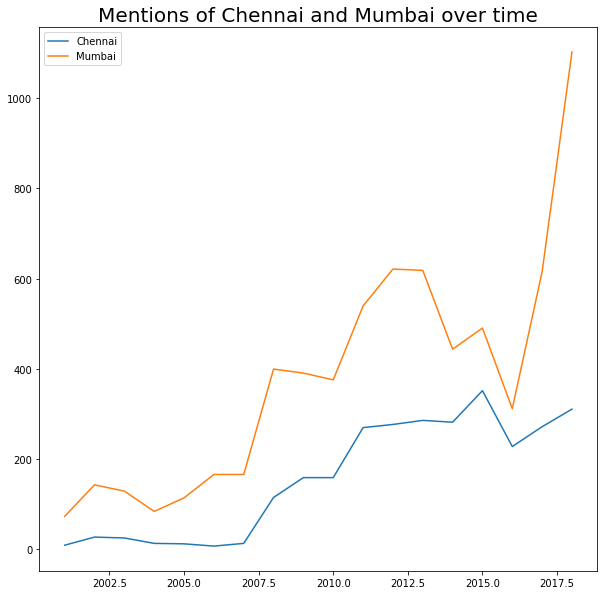

In [21]:
c=pd.DataFrame(data['year'].loc[index_chennai].value_counts())
m=pd.DataFrame(data['year'].loc[index_mumbai].value_counts())
c_m=pd.concat([c,m],axis=1)
c_m.columns=["Chennai","Mumbai"]

c_m.plot(figsize=(10,10))
plt.title("Mentions of Chennai and Mumbai over time",fontsize=20)


# Deep dive into chennai

What were the headlines about chennai?


In [22]:

import textblob
data_chennai=data.loc[index_chennai].copy()
data_chennai['polarity']=data_chennai['headline_text'].map(lambda x: textblob.TextBlob(x).sentiment.polarity)
pos=" ".join(data_chennai.query("polarity>0")['headline_text'].tolist())
neg=" ".join(data_chennai.query("polarity<0")['headline_text'].tolist())
text=" ".join(data_chennai['headline_text'].tolist())


(-0.5, 4999.5, 2499.5, -0.5)

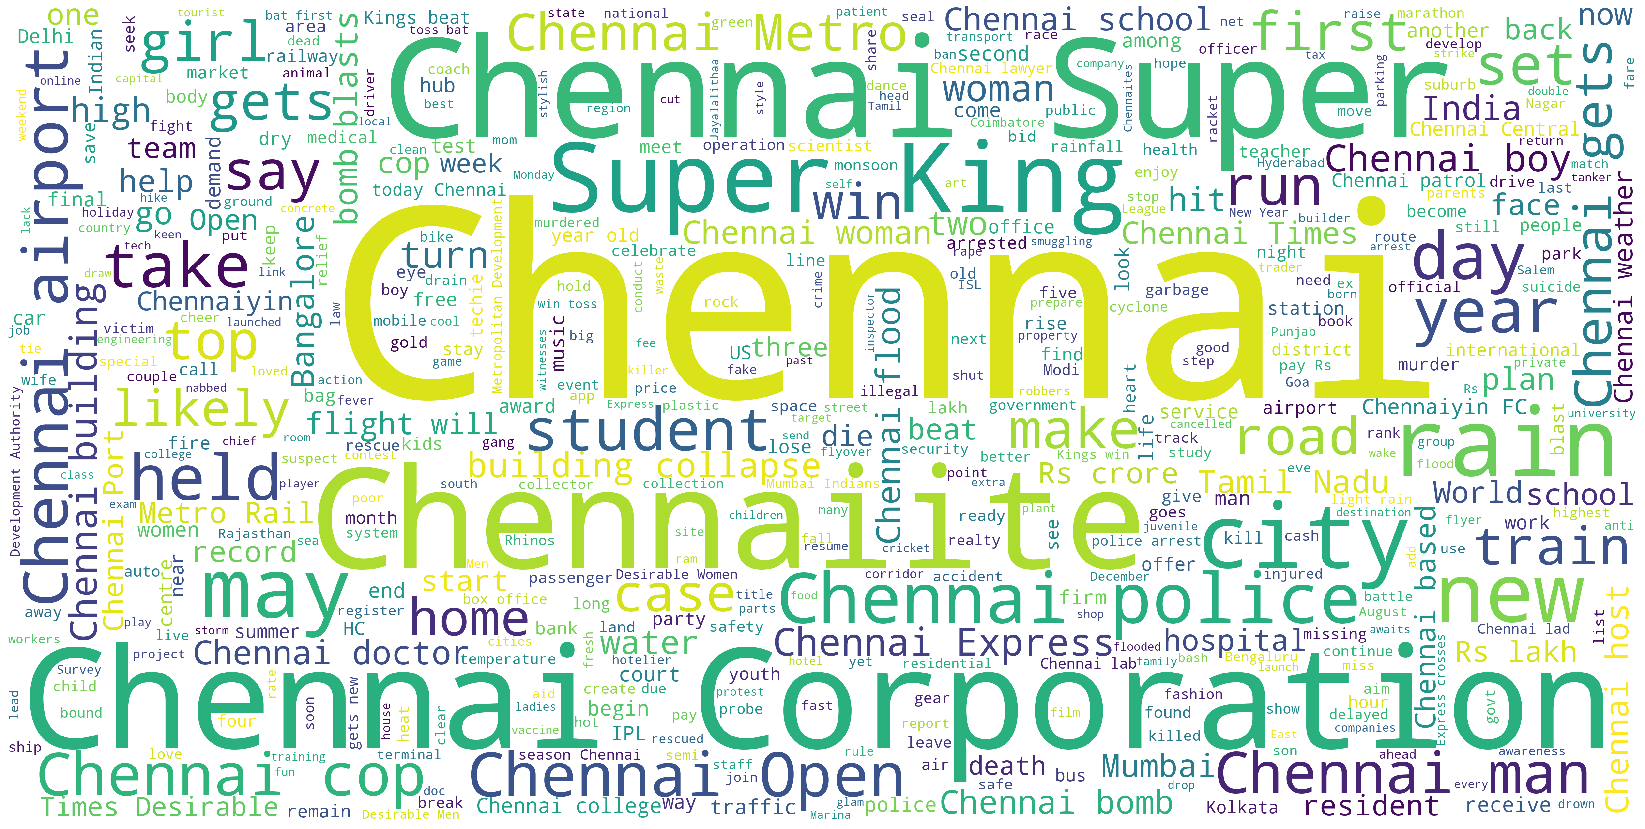

In [23]:
from wordcloud import WordCloud,STOPWORDS
import PIL
wc = WordCloud(max_words=500 ,width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(text)
plt.figure( figsize=(30,15) )
plt.imshow(wc)
plt.yticks([])
plt.xticks([])
plt.axis("off")


Let's look at some syntactic and symantic elements in these headlines


In [24]:
## top trigrams
from sklearn.feature_extraction import text
def get_imp(bow,mf,ngram):
    tfidf=text.CountVectorizer(bow,ngram_range=(ngram,ngram),max_features=mf,stop_words='english')
    matrix=tfidf.fit_transform(bow)
    return pd.Series(np.array(matrix.sum(axis=0))[0],index=tfidf.get_feature_names()).sort_values(ascending=False).head(100)
bow=data_chennai['headline_text'].tolist()
chennai_trigrams=get_imp(bow,mf=5000,ngram=3)


In [25]:
text_chennai=data_chennai['headline_text'].tolist()
noun_chennai=[]
verb_chennai=[]
for doc in nlp.pipe(text_chennai,n_threads=16,batch_size=1000):
    try:
        for c in doc:
            if c.pos_=='NOUN':
                noun_chennai.append(c.text)
            elif c.pos_=="VERB":
                verb_chennai.append(c.text)
    except:
        for c in doc:
            noun_chennai.append("") 
            verb_chennai.append("")


([], <a list of 0 Text xticklabel objects>)

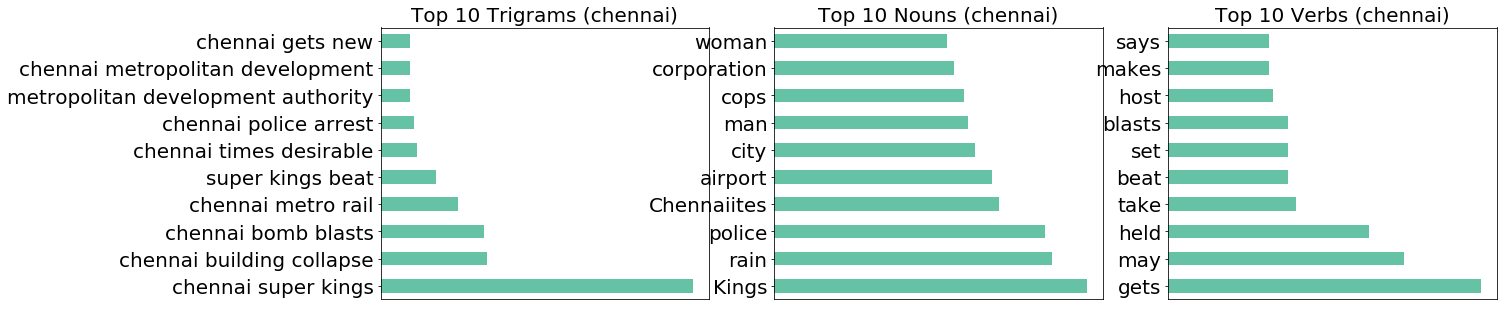

In [26]:
plt.subplot(1,3,1)
chennai_trigrams.head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Trigrams (chennai)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,2)
pd.Series(noun_chennai).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns (chennai)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,3)
pd.Series(verb_chennai).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs (chennai)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])


What did positive and negative headlines about chennai contain?



Text(0.5, 1.0, 'Negative Headlines')

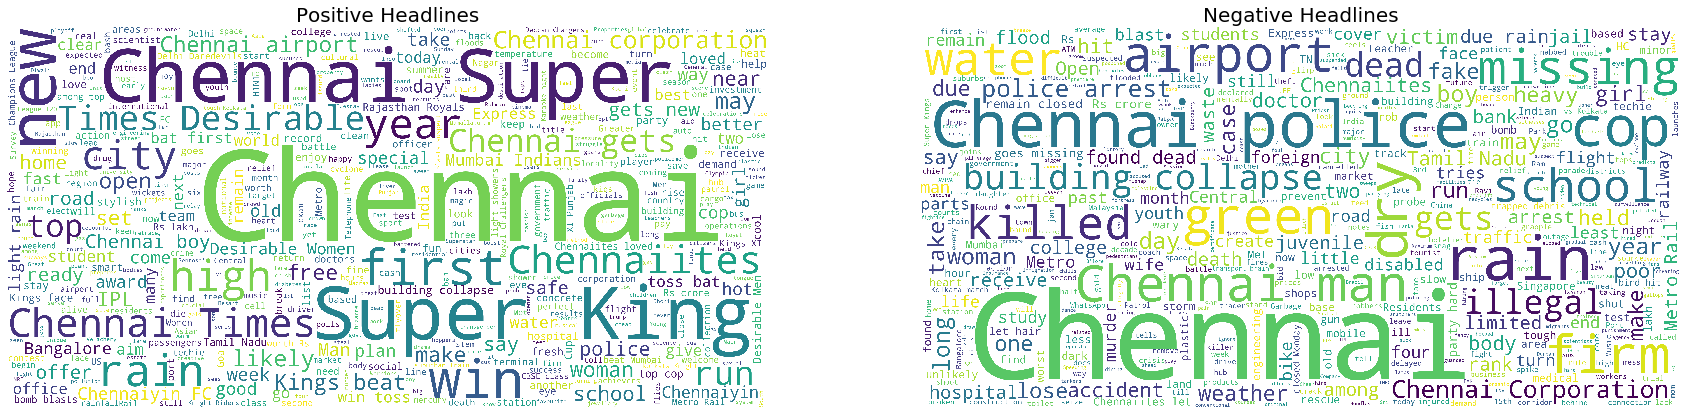

In [27]:
wc = WordCloud(max_words=500,width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(pos)

wc1=WordCloud(max_words=500, width=5000,height=2500,background_color="white",stopwords=STOPWORDS).generate(neg)
fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(1,2,1)
ax.imshow(wc)
ax.axis('off')
ax.set_title("Positive Headlines",fontdict={'fontsize':20})
ax=fig.add_subplot(1,2,2)
ax.imshow(wc1)
ax.axis('off')
ax.set_title("Negative Headlines",fontdict={'fontsize':20})


In [28]:
bow=data_chennai.query("polarity>0")['headline_text'].tolist()
chennai_trigrams_pos=get_imp(bow,mf=5000,ngram=3)
bow=data_chennai.query("polarity<0")['headline_text'].tolist()
chennai_trigrams_neg=get_imp(bow,mf=5000,ngram=3)


In [29]:
text_chennai_pos=data_chennai.query("polarity>0")['headline_text'].tolist()
noun_chennai_pos=[]
verb_chennai_pos=[]
for doc in nlp.pipe(text_chennai_pos,n_threads=16,batch_size=1000):
    try:
        for c in doc:
            if c.pos_=='NOUN':
                noun_chennai_pos.append(c.text)
            elif c.pos_=="VERB":
                verb_chennai_pos.append(c.text)
    except:
        for c in doc:
            noun_chennai_pos.append("") 
            verb_chennai_pos.append("")


In [30]:
text_chennai_neg=data_chennai.query("polarity<0")['headline_text'].tolist()
noun_chennai_neg=[]
verb_chennai_neg=[]
for doc in nlp.pipe(text_chennai_neg,n_threads=16,batch_size=1000):
    try:
        for c in doc:
            if c.pos_=='NOUN':
                noun_chennai_neg.append(c.text)
            elif c.pos_=="VERB":
                verb_chennai_neg.append(c.text)
    except:
        for c in doc:
            noun_chennai_neg.append("") 
            verb_chennai_neg.append("")


Let's look at the most common verbs, nouns and trigrams used when positive news about chennai was reported


([], <a list of 0 Text xticklabel objects>)

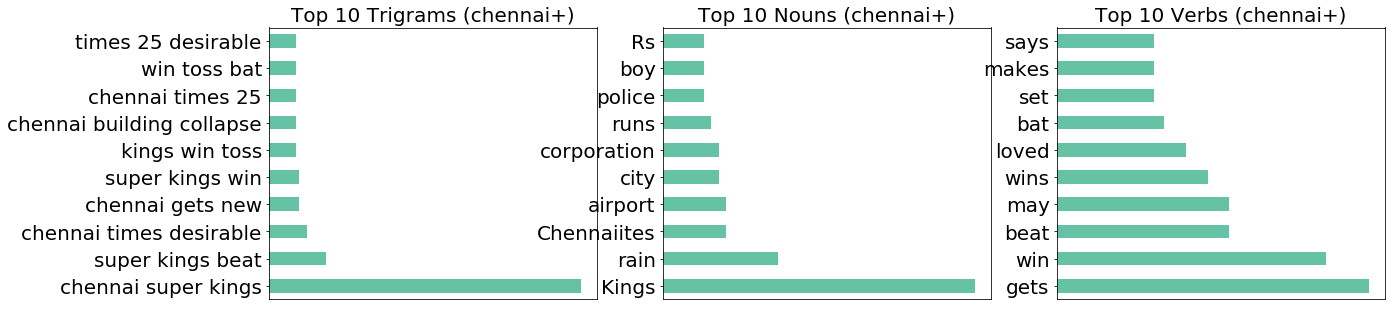

In [31]:
plt.subplot(1,3,1)
chennai_trigrams_pos.head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Trigrams (chennai+)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,2)
pd.Series(noun_chennai_pos).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns (chennai+)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,3)
pd.Series(verb_chennai_pos).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs (chennai+)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])


Let's look at the most common verbs, nouns and trigrams used when negative news about chennai was reported

([], <a list of 0 Text xticklabel objects>)

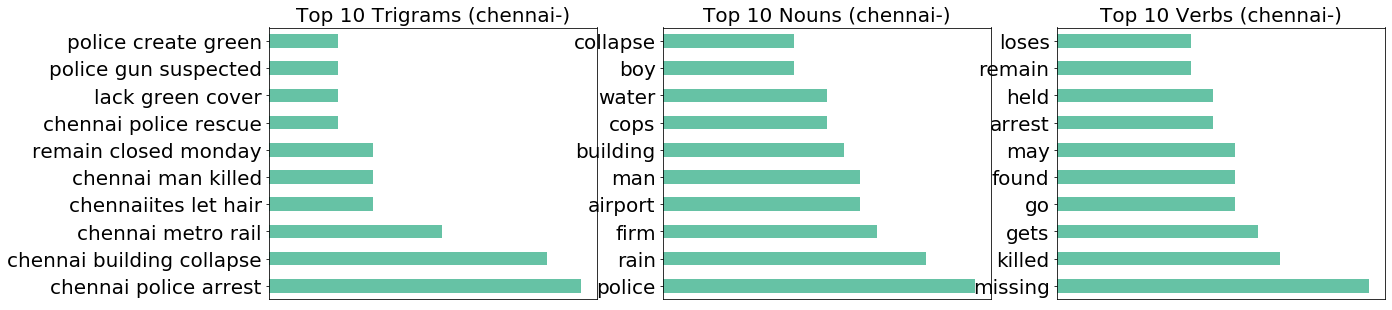

In [32]:
plt.subplot(1,3,1)
chennai_trigrams_neg.head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Trigrams (chennai-)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,2)
pd.Series(noun_chennai_neg).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Nouns (chennai-)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])
plt.subplot(1,3,3)
pd.Series(verb_chennai_neg).value_counts().head(10).plot(kind="barh",figsize=(20,5),colormap="Set2")
plt.title("Top 10 Verbs (chennai-)",fontsize=20)
plt.yticks(size=20)
plt.xticks([])